In [38]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [10]:
# Load the dataset
file_path = './final_data_with_crime_severity.csv'
data = pd.read_csv(file_path)

# Drop irrelevant columns (e.g., non-numeric, identifiers, etc.)
irrelevant_cols = ['Unnamed: 0', 'index', 'most_freq_ofns_desc', 
                   'most_freq_loc_occur', 'most_freq_prem_type',
                   'most_freq_susp_age_group', 'most_freq_susp_race', 
                   'most_freq_susp_sex', 'most_freq_vic_age_group', 
                   'most_freq_vic_race', 'most_freq_vic_sex']
data = data.drop(columns=irrelevant_cols, errors='ignore')

# Drop rows with missing values
data = data.dropna()

# Separate features (X) and target variable (y)
X = data.drop(columns=['crime_severity', 'zipcode'])
y = data['crime_severity']

# Ensure the target variable is categorical
y = y.astype('int')


In [11]:
# Split into train (60%), validation (20%), and test (20%) sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

In [35]:
# Initialize the XGBoost classifier
xgb_model = XGBClassifier(random_state=42, eval_metric='mlogloss')

# Adjust the target variable to start from 0 instead of 1
y_train_adjusted = y_train - 1
y_val_adjusted = y_val - 1
y_test_adjusted = y_test - 1

# Train the XGBoost model with the adjusted target variable
xgb_model.fit(X_train, y_train_adjusted)


# Make predictions on the validation set
val_pred = xgb_model.predict(X_val)

# Evaluate the model using accuracy and classification report
print("Validation Accuracy:", accuracy_score(y_val_adjusted, val_pred))
print("\nClassification Report on Validation Set:\n", classification_report(y_val_adjusted, val_pred))

# Make predictions on the test set
test_pred = xgb_model.predict(X_test)

# Evaluate the model on the test set
print("Test Accuracy:", accuracy_score(y_test_adjusted, test_pred))
print("\nClassification Report on Test Set:\n", classification_report(y_test_adjusted, test_pred))

Validation Accuracy: 0.9166666666666666

Classification Report on Validation Set:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.75      0.86         8
           2       1.00      0.67      0.80         3
           3       0.78      1.00      0.88         7

    accuracy                           0.92        36
   macro avg       0.93      0.85      0.88        36
weighted avg       0.93      0.92      0.91        36

Test Accuracy: 0.8888888888888888

Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       0.90      0.82      0.86        11
           2       1.00      0.88      0.93         8
           3       0.82      0.90      0.86        10

    accuracy                           0.89        36
   macro avg       0.90      0.90      0.90        36
weighted avg       0.89      0.

In [36]:
param_grid = {
    'n_estimators': [100, 200, 300],          # Number of trees in the forest
    'max_depth': [3, 6, 9],                   # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.2],        # Step size shrinkage
    'subsample': [0.6, 0.8, 1.0],             # Fraction of samples used for training each tree
    'colsample_bytree': [0.6, 0.8, 1.0],      # Fraction of features used per tree
    'gamma': [0, 0.1, 0.2],                   # Minimum loss reduction for a split
    'reg_alpha': [0, 0.1, 1],                 # L1 regularization term
    'reg_lambda': [1, 1.5, 2]                 # L2 regularization term
}

In [39]:
# Initialize the model
xgb_model = XGBClassifier(random_state=42, eval_metric='mlogloss')

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Perform the hyperparameter search
random_search.fit(X_train, y_train_adjusted)

# Print the best parameters and score
print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200, reg_alpha=0.1, reg_lambda=2, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=200, reg_alpha=0.1, reg_lambda=2, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=6, n_estimators=200, reg_alpha=1, reg_lambda=1.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=6, n_estimators=200, reg_alpha=1, reg_lambda=1.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=6, n_estimators=200, reg_alpha=1, reg_lambda=1.5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_de

In [40]:
# Retrieve the best model
best_xgb_model = random_search.best_estimator_

# Evaluate on validation and test sets
val_pred = best_xgb_model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val_adjusted, val_pred))
print("\nClassification Report on Validation Set:\n", classification_report(y_val_adjusted, val_pred))

test_pred = best_xgb_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test_adjusted, test_pred))
print("\nClassification Report on Test Set:\n", classification_report(y_test_adjusted, test_pred))


Validation Accuracy: 0.9166666666666666

Classification Report on Validation Set:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95        18
           1       1.00      0.62      0.77         8
           2       1.00      1.00      1.00         3
           3       0.88      1.00      0.93         7

    accuracy                           0.92        36
   macro avg       0.94      0.91      0.91        36
weighted avg       0.93      0.92      0.91        36

Test Accuracy: 0.9444444444444444

Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.91      0.95        11
           2       1.00      0.88      0.93         8
           3       0.91      1.00      0.95        10

    accuracy                           0.94        36
   macro avg       0.95      0.95      0.94        36
weighted avg       0.95      0.

In [48]:
# Display feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': best_xgb_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)

                Feature  Importance
3      num_total_crimes    0.180914
2       num_misdemeanor    0.172717
1         num_violation    0.121788
7    num_police_station    0.118589
0            num_felony    0.089558
6      num_stopandfrisk    0.072864
8          num_restroom    0.063577
4         median_income    0.052938
11           population    0.046577
10  num_subway_stations    0.031039
5     unemployment_rate    0.029840
9         num_bus_stops    0.019598


In [ ]:
# Get probabilities for AUC calculation
val_proba = best_xgb_model.predict_proba(X_val)
test_proba = best_xgb_model.predict_proba(X_test)

# Compute AUC score
val_auc = roc_auc_score(y_val_adjusted, val_proba, multi_class='ovr')
test_auc = roc_auc_score(y_test_adjusted, test_proba, multi_class='ovr')

print(f"Validation AUC Score: {val_auc}")
print(f"Test AUC Score: {test_auc}")


Validation AUC Score: 0.9988839285714286
Test AUC Score: 0.9981293706293706


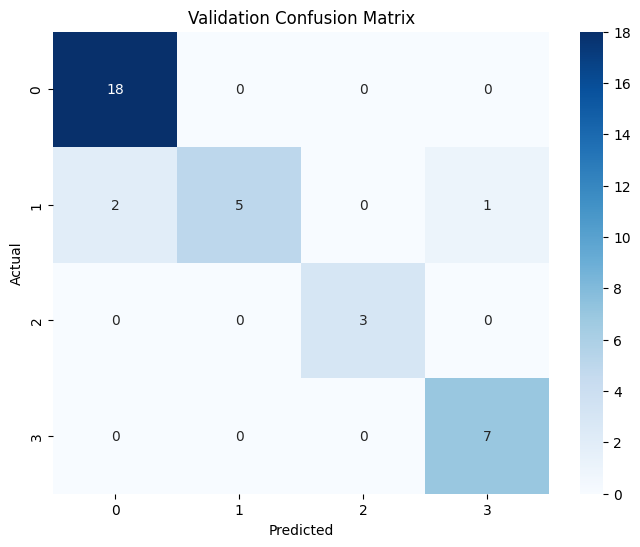

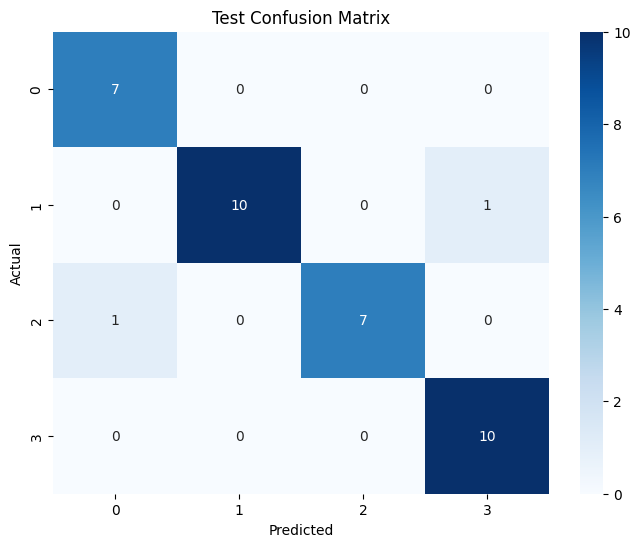

In [47]:
# Compute confusion matrix for validation set
val_cm = confusion_matrix(y_val_adjusted, val_pred)

# Compute confusion matrix for test set
test_cm = confusion_matrix(y_test_adjusted, test_pred)

# Visualize confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('./visuals/xgb {}.png'.format(title))
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(val_cm, "Validation Confusion Matrix")
plot_confusion_matrix(test_cm, "Test Confusion Matrix")
